In [1]:
import math
import numpy
import torch
import torch.nn as nn
import torchaudio
torchaudio.set_audio_backend("soundfile")
import matplotlib.pyplot as plt

C:\Users\Jokla\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
class AudioSample:
    def __init__(self, filepath):
        loadedData = torchaudio.load(filepath)
        self.waveform = loadedData[0][0]
        self.sampleRate = loadedData[1]
        del loadedData
        self.pitchDeltas = torch.tensor([], dtype = int)
        self.pitchBorders = torch.tensor([], dtype = int)
        self.Pitch = torch.tensor([0], dtype = int)
        self.spectra = torch.tensor([[]], dtype = float)
        self.spectrum = torch.tensor([], dtype = float)
        self.excitation = torch.tensor([], dtype = float) #replace with periodic and aperiodic excitation once implemented
    def CalculatePitch(self, expectedPitch, searchRange = 0.2):
        batchSize = math.floor((1. + searchRange) * self.sampleRate / expectedPitch)
        lowerSearchLimit = math.floor((1. - searchRange) * self.sampleRate / expectedPitch)
        batchStart = 0
        while batchStart + batchSize <= self.waveform.size()[0] - batchSize:
            sample = torch.index_select(self.waveform, 0, torch.linspace(batchStart, batchStart + batchSize, batchSize, dtype = int))
            zeroTransitions = torch.tensor([], dtype = int)
            for i in range(lowerSearchLimit, batchSize):
                if (sample[i-1] < 0) and (sample[i] > 0):
                    zeroTransitions = torch.cat([zeroTransitions, torch.tensor([i])], 0)
            error = math.inf
            delta = math.floor(self.sampleRate / expectedPitch)
            for i in zeroTransitions:
                shiftedSample = torch.index_select(self.waveform, 0, torch.linspace(batchStart + i.item(), batchStart + batchSize + i.item(), batchSize, dtype = int))
                newError = torch.sum(torch.pow(sample - shiftedSample, 2))
                if error > newError:
                    delta = i.item()
                    error = newError
            self.pitchDeltas = torch.cat([self.pitchDeltas, torch.tensor([delta])])
            batchStart += delta
        nBatches = self.pitchDeltas.size()[0]
        self.pitchBorders = torch.zeros(nBatches + 1, dtype = int)
        for i in range(nBatches):
            self.pitchBorders[i+1] = self.pitchBorders[i] + self.pitchDeltas[i]
        self.Pitch = torch.mean(self.pitchDeltas.float()).int()
        del batchSize
        del lowerSearchLimit
        del batchStart
        del sample
        del zeroTransitions
        del error
        del delta
        del shiftedSample
        del newError
        del nBatches
    def CalculateSpectra(self, iterations = 10, filterWidth = 20):
        Window = torch.hann_window(self.Pitch * 3)
        signals = torch.stft(self.waveform, 3 * self.Pitch, hop_length = self.Pitch, win_length = 3 * self.Pitch, window = Window, return_complex = True)
        signals = torch.transpose(signals, 0, 1)
        workingSpectra = signals.abs()
        self.spectra = torch.full_like(workingSpectra, -float("inf"), dtype=torch.float)
        for i in range(iterations):
            workingSpectra = torch.max(workingSpectra, self.spectra)
            self.spectra = workingSpectra
            for i in range(filterWidth):
                self.spectra = torch.roll(workingSpectra, -i, dims = 1) + self.spectra + torch.roll(workingSpectra, i, dims = 1)
            self.spectra = self.spectra / (2 * filterWidth + 1)
        self.spectrum = torch.mean(self.spectra, 0)
        for i in range(self.spectra.size()[0]):
            self.spectra[i] = self.spectra[i] - self.spectrum
        del Window
        del signals
        del workingSpectra
    def CalculateExcitation(self):
        Window = torch.hann_window(self.Pitch * 3)
        signals = torch.stft(self.waveform, 3 * self.Pitch, hop_length = self.Pitch, win_length = 3 * self.Pitch, window = Window, return_complex = True)
        signals = torch.transpose(signals, 0, 1)
        excitations = torch.empty_like(signals)
        for i in range(excitations.size()[0]):
            excitations[i] = signals[i] / (self.spectrum + self.spectra[i])
        excitations = torch.transpose(excitations, 0, 1)
        self.excitation = torch.istft(excitations, 3 * self.Pitch, hop_length = self.Pitch, win_length = 3 * self.Pitch, window = Window, onesided = True)
        del Window
        del signals
        del excitations

In [3]:
class Synthesizer:
    def __init__(self, Excitation, Spectrum, Spectra, SampleRate):
        self.excitation = Excitation
        self.spectrum = Spectrum
        self.spectra = Spectra
        self.sampleRate = SampleRate
        self.returnSignal = torch.tensor([], dtype = float)
    def Synthesize(self, pitch, steadiness):
        Window = torch.hann_window(pitch * 3)
        self.returnSignal = torch.stft(self.excitation, 3 * pitch, hop_length = pitch, win_length = 3 * pitch, window = Window, return_complex = True)
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)
        for i in range(self.spectra.size()[0]):
            self.returnSignal[i] = self.returnSignal[i] * (self.spectrum + math.pow(1 - steadiness, 2) * torch.roll(self.spectra, 0, dims=0)[i])
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)
        self.returnSignal = torch.istft(self.returnSignal, 3 * pitch, hop_length = pitch, win_length = 3 * pitch, window = Window, onesided=True, )
        del Window
    def save(self, filepath):
        torchaudio.save(filepath, torch.unsqueeze(self.returnSignal, 0), self.sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)

In [4]:
class SpecCrfAi(nn.Module):
    def __init__(self, inputsize, learningRate=1e-3):
        super(SpecCrfAi, self).__init__()
        
        self.size1 = int(inputsize * 2 + 1)
        self.size2 = int(inputsize * 1.75 + 0.75)
        self.size3 = int(inputsize * 1.5 + 0.5)
        self.size4 = int(inputsize * 1.25 + 0.25)
        self.size5 = int(inputsize)
        
        self.NeuralNet = nn.Sequential(nn.Linear(self.size1, self.size2),
                                     nn.ReLU(True),
                                     nn.Linear(self.size2, self.size3),
                                     nn.ReLU(True),
                                     nn.Linear(self.size3, self.size4),
                                     nn.ReLU(True),
                                     nn.Linear(self.size4, self.size5))

        self.learningRate = learningRate

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learningRate, weight_decay=1e-5)
        self.criterion = nn.MSELoss()
        
    def forward(self, spectrum1, spectrum2, factor):
        x = torch.cat((spectrum1, spectrum2, torch.tensor([factor])), dim = 0)
        x = x.float()
        x = self.NeuralNet(x)
        return x
    
    def processData(self, spectrum1, spectrum2, factors):
        spectrum1 = torch.log(spectrum1)
        spectrum2 = torch.log(spectrum2)
        output = torch.tensor([[]], dtype = float)
        for i in factors:
            result = torch.unsqueeze(self(spectrum1, spectrum2, i), dim = 0)
            output = torch.cat((output, result), dim = 1)
        output = torch.exp(output)
        return output
    
    def train(self, indata, epochs=1):
        for epoch in range(epochs):
            for data in self.dataLoader(indata):
                spectrum1 = data[0]
                spectrum2 = data[-1]
                spectrum1 = torch.log(spectrum1)
                spectrum2 = torch.log(spectrum2)
                indexList = numpy.arange(0, data.size()[0], 1)
                numpy.random.shuffle(indexList)
                for i in indexList:
                    factor = i / float(data.size()[0])
                    spectrumTarget = data[i]
                    spectrumTarget = torch.log(spectrumTarget)
                    output = self(spectrum1, spectrum2, factor)
                    loss = self.criterion(output, spectrumTarget)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

            print('epoch [{}/{}], loss:{:.4f}'
                  .format(epoch + 1, epochs, loss.data))
            
    def dataLoader(self, data):
        return torch.utils.data.DataLoader(dataset=data, shuffle=True)

In [5]:
audioSample = AudioSample("Samples/a_i.wav")
audioSample.CalculatePitch(95.)
audioSample.CalculateSpectra()
audioSample.CalculateExcitation()

In [6]:
synthesizer = Synthesizer(audioSample.excitation, audioSample.spectrum, audioSample.spectra, audioSample.sampleRate)
synthesizer.Synthesize(audioSample.Pitch, 1.)
synthesizer.save("Output_high_Steadiness.wav")

In [7]:
trainSpectra = torch.empty_like(audioSample.spectra)
for i in range(audioSample.spectra.size()[0]):
    trainSpectra[i] = audioSample.spectrum + audioSample.spectra[i]
specCrfAi = SpecCrfAi(trainSpectra.size()[1])
specCrfAi.train(trainSpectra, epochs = 10)

epoch [1/10], loss:5.1008
epoch [2/10], loss:0.1183
epoch [3/10], loss:0.0603
epoch [4/10], loss:0.1178
epoch [5/10], loss:0.2718
epoch [6/10], loss:0.0853
epoch [7/10], loss:0.0674
epoch [8/10], loss:0.0865
epoch [9/10], loss:0.0496
epoch [10/10], loss:0.0321


In [8]:
output = specCrfAi.processData(trainSpectra[0], trainSpectra[-1], [0.5]).detach()

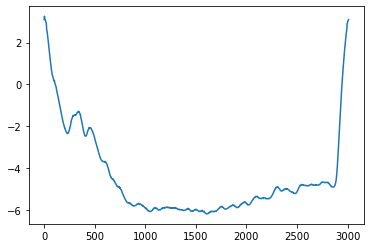

In [13]:
plt.plot(torch.log(trainSpectra[10]))

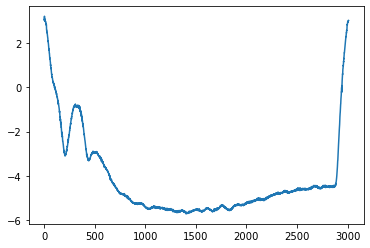

In [10]:
plt.plot(torch.log(output[0]))

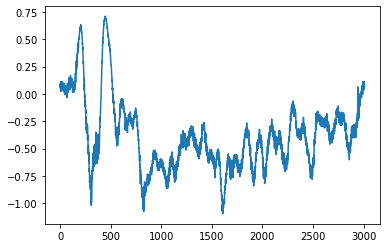

In [18]:
plt.plot((trainSpectra[10] - output[0]) / trainSpectra[10])